In [5]:
from songs import *

# НЕЙРОНКИ

In [6]:
import numpy as np
from numpy import random
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
MEMORY_TIMES = 64
STARTER = 8

ADDITIONAL_MEMORY = 8

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY

In [8]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]
NAMES = []
for i in range(8):
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [75]:
TURNED = []  # список включившихся нейронов
class Neuron:
    def __init__(self, name, layer, isnot=False):
        self.name = name
        self.layer = layer  # номер слоя
        
        self.outputs = []  # список нейронов-выходов
        self.cnt = 0       # подсчёт пришедшего числа сигналов
        self.n = isnot     # инвертирует ли выход
        
        self.inputs = []   # входные связи и их оценки
        self.rewards = []
        self.precedents = []
        
    def signal(self):
        self.cnt += 1        
        
    def emit(self):
        thr = len(self.inputs) // 2
        
        if ((not self.n and self.cnt > thr) or (self.n and self.cnt <= thr)):  # включение нейрона
            TURNED.append(self)
            
            for neuron in self.outputs:
                neuron.signal()
                
    def reward(self, true_val):  # оценивание связей
        if self.n:
            true_val = not true_val  # нужно ли было выключаться
            
        decision = self in TURNED  # был ли включён этот нейрон
        
        for i, inp in enumerate(self.inputs):
            my_val = inp in TURNED  # входной сигнал
            if my_val == decision:  # интересная эвристика: оцениваем только когда решение было за нейроном
                self.precedents[i][my_val] += 1
                if my_val == true_val:
                    self.rewards[i][my_val] += 1
                inp.reward(true_val)  # переходим во вход рекурсивно

In [114]:
class Func:
    def __init__(self, layers, verbose=False):
        self.layers = layers
        self.neurons = [Neuron(NAMES[i], 0) for i in range(MEMORY_SIZE)]  # входы
        for i in range(13):                                               # выходы
            self.neurons.append(Neuron(NOTE_NAMES[i] + "outp", layers)) 
        self.ids = len(self.neurons)       
        
        self.Random = np.random.RandomState(seed=179)        
        self.verbose = verbose
        self.depth = ""
        
    def apply(self, x):  # проход по нейросети
        global TURNED    # сначала всё выключаем
        TURNED = []
        for neuron in self.neurons:
            neuron.cnt = 0
            
        for i, val in enumerate(x):  # посылаем сигналы на нужные входы
            if val == 1:
                self.neurons[i].signal()
                
        for layer in range(0, self.layers + 1):  # проходимся по слоям
            for N in self.neurons:
                if N.layer == layer:
                    N.emit()
        
        # собираем включившиеся выходы
        return np.array([self.neurons[MEMORY_SIZE + i] in TURNED for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            self.neurons[i + MEMORY_SIZE].reward(val)
    
    def randomOne(self, layer):
        # выбираем случайный включившийся нейрон
        for i in range(self.layers - layer + 1):
            N = TURNED[self.Random.randint(len(TURNED))]
            if N.layer < layer:
                return N
        return False
    def connect(self, N1, N2, rewards=[1, 2], precedents=[2, 3]):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        if N1 in N2.inputs:
            if self.verbose:
                print(self.depth, "tried to create existing edge, procedure failed")
            return False
        
        if self.verbose:
            print(self.depth, "new edge between layers: ", N1.name, "(", N1.layer, ")", " / ", N2.name, "(", N2.layer, ")")
        N1.outputs.append(N2)
        N2.inputs.append(N1)
        N2.rewards.append(copy.copy(rewards))
        N2.precedents.append(copy.copy(precedents))
        return True
    def check_for_blow(self, N):
        # проверяем нейрон; если у него нет входов или выходов, взрываем
        
        if not N in self.neurons: #возможно, он уже взорван
            return True
        if N.layer == 0 or N.layer == self.layers: # возможно, это вход или выход
            return False
        
        if len(N.outputs) == 0:
            if self.verbose:
                print(self.depth, "neuron destroyed! ", N.name, "(", N.layer, ")")
            for inp in N.inputs:
                self.disconnect(inp, N)  # возможны рекурсивные взрывы
        elif len(N.inputs) == 0:
            if self.verbose:
                print(self.depth, "neuron destroyed! ", N.name, "(", N.layer, ")")
            for outp in N.outputs:
                self.disconnect(N, outp)  # возможны рекурсивные взрывы
        else:
            return False  # взрыва не произошло
            
        # при взрыве удаляем нейрон из списка включившихся и из списка нейронов
        if N in TURNED:
            TURNED.remove(N)
        if N in self.neurons:
            self.neurons.remove(N)
        return True
    def disconnect(self, N1, N2):
        # разъединяем связь
        if self.verbose:
            print(self.depth, "remove edge between layers: ", N1.name, "(", N1.layer, ")", " / ", N2.name, "(", N2.layer, ")")
        N1.outputs.remove(N2)
        del N2.rewards[N2.inputs.index(N1)]
        del N2.precedents[N2.inputs.index(N1)]
        N2.inputs.remove(N1)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать        
        self.check_for_blow(N1)
        self.check_for_blow(N2)
        
        '''  проверка на o-o-o, пока не заработало
        if len(N1.inputs) == 1 and len(N1.outputs) == 1 and not N1.n:
            self.connect(N1.inputs[0], N1.outputs[0], N1.rewards[0], N1.precedents[0])
            self.disconnect(N1.inputs[0], N1)
            #self.disconnect(N1, N1.outputs[0])
        if len(N2.inputs) == 1 and len(N2.outputs) == 1 and not N2.n:
            self.connect(N2.inputs[0], N2.outputs[0], N2.rewards[0], N2.precedents[0])
            self.disconnect(N2.inputs[0], N2)
            #self.disconnect(N2, N2.outputs[0])
        '''  
        
    def add_reason(self, conseq):
        # добавление причины
        if conseq.layer <= 1:
            if self.verbose:
                print(self.depth, "no place for reason :(")
            return None
        
        reason = Neuron("rsn" + str(self.ids), self.Random.randint(1, conseq.layer), True)
        self.neurons.append(reason)
        self.ids += 1
        
        if self.verbose:
            print(self.depth, "created reason ", reason.name, " (", reason.layer, ")")
        
        self.connect(reason, conseq)        
        return reason
    def add_stub(self, cause, conseq, stublayer):
        # добавление заглушки
        if conseq.layer <= 1 or conseq.layer - cause.layer <= 1:
            if self.verbose:
                print(self.depth, "no place for stub :(")
            return None
        
        stub = Neuron("stub" + str(self.ids), stublayer)
        self.neurons.append(stub)
        self.ids += 1
        
        if self.verbose:
            print(self.depth, "created stub ", stub.name, " (", stublayer, ")")
        
        # оценки связей берём из разорванной связи
        r, p = conseq.rewards[conseq.inputs.index(cause)], conseq.precedents[conseq.inputs.index(cause)]
        self.connect(cause, stub, r, p)
        self.connect(stub, conseq, r, p)
        self.disconnect(cause, conseq)
                
        return stub
        
    def turn(self, N, pos, no_recursion=False):
        # АЛГОРИТМ ПОПРАВКИ!
        self.depth += "    "
        
        # Если мы оказались на входе, то сразу говорим, что ничего не вышло
        if N.layer == 0:
            if self.verbose:
                print(self.depth, N.name, " is input neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False
        
        if self.verbose:
            print(self.depth, "turning ", pos, ": ", N.name)
        
        # Если из нейрона выходит отрицание, то нам нужно получить значение, обратное к pos
        if N.n:
            pos = not pos
            if self.verbose:
                print(self.depth, "actualy ", pos, ": ", N.name)
        
        # значение импульса в нейроне на текущий момент
        votes = N.cnt
        
        if not no_recursion:  # запрет на рекурсию выставляется в том случае, если мы правим новую заглушку
            for taken, rew, pr in zip(N.inputs, N.rewards, N.precedents):
                if taken in N.inputs and (taken in TURNED) != pos:  # перебираем входы с неверным пришедшим сигналом
                    
                    # этот узел виновник с вероятностью своей неправоты!
                    # возведение в степень taken.layer позволяет добраться до внутренних узлов
                    if self.Random.uniform(0, 1) > (rew[int(not pos)] / pr[int(not pos)])**taken.layer:
                        
                        # первый вариант: разрубить связь и вставить заглушку.
                        # выбираем этот вариант тем вероятнее, чем больше разница между качеством связи для 0 и 1  
                        if (taken.layer + 1 < N.layer and
                            self.Random.uniform(0, 1) < rew[int(not pos)] / pr[int(not pos)] - rew[int(pos)] / pr[int(pos)]):
                            stublayer = self.Random.randint(taken.layer + 1, N.layer)             
                            stub = self.add_stub(taken, N, stublayer)
                            result = self.turn(stub, pos, no_recursion=True)
                            
                            if pos == 0:
                                stub.cnt += 1

                            # если исправить вход не получилось, да ну его нафиг
                            if not result:
                                self.disconnect(stub, N)
                        else: # второй вариант - пытаться исправить его рекурсивно
                            result = self.turn(taken, pos)                  
                            
                            # если исправить вход не получилось, да ну его нафиг                        
                            if not result:
                                self.disconnect(taken, N)

                        # нейрон, в котором мы сейчас сидим, может взорваться по цепочке;
                        # в таком случае, алгоритм типауспешно заканчивается
                        if not N in self.neurons:
                            if self.verbose and not result:
                                print(self.depth, "we blowed up!")
                            self.depth = self.depth[:-4]
                            return True

                        # так или иначе мы получили голос в правильном направлении!
                        if pos == 0:
                            votes -= 1
                        else:  # вообще-то это неверно, если связь удал., то количество голосов не изменилось
                            votes += 1
        
        # результат процедуры
        new_pos = votes > (len(N.inputs)) // 2
        
        # если проход по связям не удался, надо добавлять новые связи
        if new_pos != pos:
            if self.verbose:
                print(self.depth, "didn't fix voting situation...")
            
            if pos == 1:  # добавлять новые нити
                result = False
                one = self.randomOne(N.layer)
                if one:
                    result = result or self.connect(one, N)
                if result:
                    votes += 1               
            else:  # добавлять причины
                result = False
                reason = self.add_reason(N)
                if not reason is None:
                    result = self.turn(reason, pos)
                    if result:
                        votes -= 1
                else:
                    result = False
        else:
            result = True
       
        # итоговый результат
        new_pos = votes > (len(N.inputs)) // 2               
        
        if self.verbose and new_pos != pos:
            print(self.depth, "procedure failed")
        self.depth = self.depth[:-4]
        return new_pos == pos
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            dot.node(N.name)
        for N in self.neurons:
            for inp, r, p in zip(N.inputs, N.rewards, N.precedents):
                dot.edge(inp.name, N.name, label = "{0:.2f}".format(r[0] / p[0])  + "/" + "{0:.2f}".format(r[1] / p[1]))
        #dot.render(view=True)
        return dot

In [115]:
class Player:
    def __init__(self):
        self.play_note = Func(6)
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[note + MEMORY_SIZE], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[note + MEMORY_SIZE], 0)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [116]:
player = Player()

In [117]:
kuznechik = Song('../basic midi/track (1).mid')

In [118]:
player.learn_to_play(kuznechik, verbose=True, limit=13)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  Aoutp
     didn't fix voting situation...
     new edge between layers:  A-8 ( 0 )  /  Aoutp ( 6 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp
     didn't fix voting situation...
     new edge between layers:  A-6 ( 0 )  /  G#outp ( 6 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0]
     turning  1 :  G#outp
     didn't fix voting situation...
     new edge between layers:  E-6 ( 0 )  /  G#outp ( 6 )
     procedure failed
     turning  0 :  Aoutp
     didn't fix voting situation...
     created reason  rsn853  ( 5 )
     new edge between layers:  rsn853 ( 5 )  /  Aoutp ( 6 )
         turning  0 :  rsn853
         actualy  True :  rsn853
         didn't fix voting situation...
         new edge between layers:  A-12 ( 0 )  /  rsn853 ( 5 )


4

In [119]:
player.play_note.draw()

Будем добиваться, чтобы он правильно сыграл первые n долей, и постепенно увеличивать n... Текущая версия застревает на 67 - когда требуется нажать новую ноту, и нужно построить такое правило, которое включалось бы только на последней итерации

In [120]:
limit = 8
neurons = [MEMORY_SIZE + 13]

while limit < 128:#len(kuznechik.notes):
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons))
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        neurons.append(len(player.play_note.neurons))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8  neurons_at_start:  854
0 
limit:  9  neurons_at_start:  854
0 
limit:  10  neurons_at_start:  854
0 
limit:  11  neurons_at_start:  854
1 0 
limit:  12  neurons_at_start:  854
0 
limit:  13  neurons_at_start:  854
1 2 2 2 2 2 2 2 2 2 2 2 5 3 2 2 0 
limit:  14  neurons_at_start:  864
0 
limit:  15  neurons_at_start:  864
0 
limit:  16  neurons_at_start:  864
0 
limit:  17  neurons_at_start:  864
2 3 2 1 1 2 1 1 2 3 2 6 5 4 1 0 
limit:  18  neurons_at_start:  870
0 
limit:  19  neurons_at_start:  870
1 5 5 3 3 3 3 2 2 1 3 3 2 3 2 0 
limit:  20  neurons_at_start:  881
0 
limit:  21  neurons_at_start:  881
1 4 2 2 2 2 2 2 1 0 
limit:  22  neurons_at_start:  874
0 
limit:  23  neurons_at_start:  874
1 4 2 0 
limit:  24  neurons_at_start:  876
0 
limit:  25  neurons_at_start:  876
1 3 0 
limit:  26  neurons_at_start:  877
0 
limit:  27  neurons_at_start:  877
2 2 2 0 
limit:  28  neurons_at_start:  877
0 
limit:  29  neurons_at_start:  877
1 2 2 4 3 6 5 5 5 9 3 5 8 6 5 3 5 5 4 12 

KeyboardInterrupt: 

А вот стандартная процедура (несколько раз проходим по выборке). Ошибка сначала падает, потом застревает. Количество нейронов стабильно растёт.

In [121]:
player = Player()

In [122]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    neurons.append(len(player.play_note.neurons))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

56 52 54 55 54 53 53 53 53 54 53 53 53 55 52 54 53 52 52 51 51 52 51 51 52 52 51 51 51 51 51 51 51 51 51 51 51 51 51 51 53 52 51 51 52 53 52 51 52 53 53 52 53 53 53 55 54 54 53 50 51 50 52 51 51 51 49 49 48 48 49 47 49 49 49 47 49 49 49 48 48 49 49 45 46 47 46 48 44 44 42 37 36 36 34 35 35 35 38 41 36 35 34 34 30 31 27 31 29 28 28 28 23 20 27 28 27 24 26 26 29 22 24 23 23 22 25 23 20 21 16 25 21 23 23 27 30 27 23 20 22 17 15 21 21 15 22 24 24 17 14 15 12 19 16 20 19 18 17 20 24 22 26 18 16 18 16 20 18 23 18 20 22 22 19 25 16 17 17 14 19 16 21 22 17 18 17 17 15 

KeyboardInterrupt: 

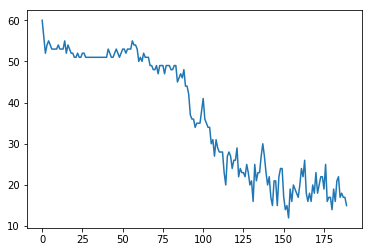

In [123]:
plt.plot(errors)  # график количества ошибок в эпоху

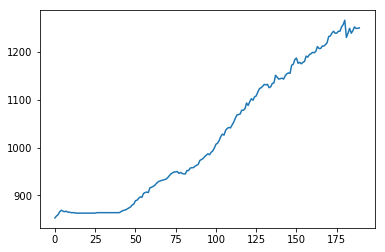

In [124]:
plt.plot(neurons)  # график количества нейронов в эпоху

In [125]:
player.play_note.draw()

In [18]:
player.play_note.draw().render('fail', view=True) 

'fail.png.png'

СНАЧАЛА БЫ ВЫУЧИТЬ КУЗНЕЧИКА!

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [ ]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [ ]:
simple_song = Song([12, -1, 11, -1, 9, -1, 7, -1])
result = player.improvise(simple_song)
result.play()

In [128]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [129]:
result.play()

KeyboardInterrupt: 

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [130]:
player = Player()

In [131]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [133]:
Songs = []
for i in range(1, 35):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

ERROR! out of range!
ERROR! out of range!
ERROR! out of range!


In [134]:
import random
random.shuffle(Songs)
prev_errors = np.array([1000 for i in range(len(Songs))])

In [ ]:
while prev_errors.sum() > 100:
    errors = []
    for song in Songs:
        errors.append(player.learn_to_play(song))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum())

39 64 65 65 42 50 49 70 44 48 48 38 44 55 51 62 50 51 51 47 71 0 0 57 58 42 53 76 40 53 56 42 53 55 42 50 51 58 42 43 52 38 40 26 0 57 55 45 42 48 52 54 65 50 72 49 34 60 44 49 54 36 40 60 48 51 41 52 47 
sum =  3336
35 51 58 57 35 50 39 73 43 47 46 38 43 48 51 60 50 48 50 47 73 0 0 52 59 40 50 73 37 52 56 41 49 53 42 46 51 58 42 40 53 38 40 26 0 58 54 48 

In [390]:
len(player.play_note.neurons)

5232

In [391]:
simple_song = Song('test/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [279]:
result.save_file("11. Voting Elephant NN cant learn kuznechik (9 errors, 4900 neurons)")

In [392]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [393]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()